# NJ Dental HPSA Equity: Comparative County Patterns (Immigration & Race Proxies)

**Research question**

> **How do Dental HPSA designation patterns differ between counties with high immigrant and minority populations versus predominantly non-immigrant counties in New Jersey?**

**What this notebook does (and does not) claim**

- We treat HRSA Dental HPSA records as an **administrative designation pattern**, not a direct measure of “true need.”
- We use **ACS county-level proxies** (% foreign-born, % Hispanic, % Black, % limited-English households) to describe **population context**.
- We **avoid causal claims** (“HRSA ignores immigrants”). We look for **differences in designation structure**.
- HPSA records can overlap (multiple designations can cover the same people/areas). Any “population covered” fields are treated as **non-deduplicated** unless otherwise stated.

---

## Setup


In [1]:
# If running in Colab, uncomment:
!pip -q install pandas numpy openpyxl requests matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

pd.set_option("display.max_columns", 200)


## 1) Inputs

Place these files in the same folder as this notebook (or update paths below):

- `BCD_HPSA_FCT_DET_DH.csv` (HRSA Dental HPSA detail file)
- `Hpsa_Find_Export.xlsx` (optional: HRSA export you used in your base notebook)


In [2]:
# -----------------------------
# CONFIG
# -----------------------------
from google.colab import drive
import os
import re
import numpy as np
import pandas as pd
import glob
drive.mount('/content/drive')

# Define your data folder
HPSA_CSV = "/content/drive/MyDrive/VasEmilio/Dental Healthcare/BCD_HPSA_FCT_DET_DH.csv"
HPSA_XLSX = "/content/drive/MyDrive/VasEmilio/Dental Healthcare/Hpsa_Find_Export.xlsx"

assert os.path.exists(HPSA_CSV), f"Missing file: {HPSA_CSV}"

print("Using:", HPSA_CSV)
print("Optional:", HPSA_XLSX, "exists?" , os.path.exists(HPSA_XLSX))


Mounted at /content/drive
Using: /content/drive/MyDrive/VasEmilio/Dental Healthcare/BCD_HPSA_FCT_DET_DH.csv
Optional: /content/drive/MyDrive/VasEmilio/Dental Healthcare/Hpsa_Find_Export.xlsx exists? True


## 2) Load HRSA Dental HPSA records and filter to New Jersey

We focus on NJ **county** patterns using `Common State County FIPS Code` (a 5-digit county GEOID).


In [3]:
hpsa = pd.read_csv(HPSA_CSV, low_memory=False)

# sanity: this file is already Dental Health in many HRSA downloads, but keep filter robust
hpsa = hpsa[hpsa["HPSA Discipline Class"].astype(str).str.contains("Dental", case=False, na=False)].copy()

nj = hpsa[hpsa["Primary State Abbreviation"] == "NJ"].copy()
print("Rows (NJ dental):", len(nj))

# County GEOID (5-digit)
nj["county_geoid"] = nj["Common State County FIPS Code"].astype(str).str.zfill(5)

# Standardize numeric score
nj["hpsa_score"] = pd.to_numeric(nj["HPSA Score"], errors="coerce")

# Basic designation type cleanup
nj["designation_type"] = nj["Designation Type"].astype(str).str.strip()

nj[["county_geoid","Common County Name","designation_type","hpsa_score"]].head()


Rows (NJ dental): 158


,county_geoid,Common County Name,designation_type,hpsa_score
7520,34041,"Warren County, NJ",Federally Qualified Health Center Look A Like,21
16247,34039,"Union County, NJ",Correctional Facility,12
16248,34019,"Hunterdon County, NJ",Correctional Facility,3
16249,34013,"Essex County, NJ",Federally Qualified Health Center,12
16250,34011,"Cumberland County, NJ",Geographic HPSA,12


## 3) County-level HPSA metrics (careful definitions)

We compute **several complementary metrics** so we don't over-interpret a single choropleth metric:

**Intensity / presence**
- `hpsa_record_count`: number of HPSA records associated with the county (record-level, not deduped)

**Severity**
- `hpsa_score_mean`: mean score across records (use with caution)
- `hpsa_score_max`: maximum score observed in the county (captures “worst-case” designations)
- `pct_high_severity_records`: share of records with score ≥ 19 (common “high” threshold in HRSA scoring contexts)

**Designation structure**
- shares of record counts by `Designation Type` (Geographic vs Population Group vs Facility)

**Population field**
- `designation_population_sum`: sum of “HPSA Designation Population” across records (**not deduplicated**)


In [4]:
def county_hpsa_metrics(nj_df: pd.DataFrame) -> pd.DataFrame:
    g = nj_df.groupby("county_geoid", dropna=False)

    out = pd.DataFrame({
        "county_geoid": g.size().index,
        "hpsa_record_count": g.size().values,
        "hpsa_score_mean": g["hpsa_score"].mean().values,
        "hpsa_score_max": g["hpsa_score"].max().values,
        "pct_high_severity_records": g["hpsa_score"].apply(lambda s: (s >= 19).mean() if s.notna().any() else np.nan).values,
        "designation_population_sum": g["HPSA Designation Population"].apply(lambda s: pd.to_numeric(s, errors="coerce").sum()).values,
        "county_name": g["Common County Name"].agg(lambda x: x.dropna().astype(str).mode().iloc[0] if x.dropna().any() else np.nan).values,
    })

    # designation type shares (by record count)
    type_ct = (nj_df
               .assign(_one=1)
               .pivot_table(index="county_geoid", columns="designation_type", values="_one", aggfunc="sum", fill_value=0))
    type_share = type_ct.div(type_ct.sum(axis=1), axis=0).add_prefix("share_type__").reset_index()

    out = out.merge(type_share, on="county_geoid", how="left")

    # a stable ordering for readability
    out = out.sort_values(["county_name","county_geoid"]).reset_index(drop=True)
    return out

county = county_hpsa_metrics(nj)
county.head()


,county_geoid,hpsa_record_count,hpsa_score_mean,hpsa_score_max,pct_high_severity_records,designation_population_sum,county_name,share_type__Correctional Facility,share_type__Federally Qualified Health Center,share_type__Federally Qualified Health Center Look A Like,share_type__Geographic HPSA,share_type__HPSA Population
0,34001,45,0.533333,24,0.022222,1071744.0,"Atlantic County, NJ",0.000000,0.022222,0.022222,0.311111,0.644444
1,34005,9,4.777778,22,0.111111,116634.0,"Burlington County, NJ",0.333333,0.111111,0.000000,0.000000,0.555556
2,34007,22,3.590909,23,0.136364,2849332.0,"Camden County, NJ",0.000000,0.181818,0.045455,0.772727,0.000000
3,34011,7,9.571429,22,0.142857,291109.0,"Cumberland County, NJ",0.571429,0.142857,0.000000,0.142857,0.142857
4,34013,8,15.375000,26,0.375000,3157604.0,"Essex County, NJ",0.125000,0.750000,0.125000,0.000000,0.000000


## 4) Pull ACS county proxies (income, race/ethnicity, language, immigration)

We use **ACS 5-year** estimates at the county level.  
This keeps interpretation conservative: we’re comparing counties, not neighborhoods.

**Variables (proxies)**
- `pop_total`: total population
- `median_household_income`
- `poverty_rate`
- `pct_foreign_born`
- `pct_black`, `pct_asian`, `pct_hispanic`
- `pct_limited_english_hh` (households with limited-English speaking)

> If you have a Census API key, set `CENSUS_API_KEY` below.  
> Many small requests work without a key, but a key is more reliable.


In [5]:
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY", "")  # optionally set as env var

# ACS 5-year endpoint (most recent available is fine for this comparative structure)
ACS_YEAR = 2022  # change if you prefer a specific year
BASE = f"https://api.census.gov/data/{ACS_YEAR}/acs/acs5"

# A compact set of ACS variables for proxies
VAR_MAP = {
    # Total pop
    "B01003_001E": "pop_total",

    # Income
    "B19013_001E": "median_household_income",

    # Poverty (below poverty / total poverty universe)
    "B17001_002E": "poverty_below",
    "B17001_001E": "poverty_total",

    # Foreign born
    "B05002_013E": "pop_foreign_born",  # foreign-born total (ACS B05002)
    # Race totals
    "B02001_003E": "pop_black",
    "B02001_005E": "pop_asian",
    # Hispanic / Latino (any race)
    "B03003_003E": "pop_hispanic",

    # Limited English speaking household proxy
    "B16002_004E": "hh_limited_english",  # "Households: Limited English speaking household"
    "B16002_001E": "hh_total",
}

def fetch_acs_county_nj(var_map: dict) -> pd.DataFrame:
    vars_list = ["NAME"] + list(var_map.keys())
    params = {
        "get": ",".join(vars_list),
        "for": "county:*",
        "in": "state:34",   # NJ
    }
    if CENSUS_API_KEY:
        params["key"] = CENSUS_API_KEY

    r = requests.get(BASE, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()

    df = pd.DataFrame(data[1:], columns=data[0])
    df["county_geoid"] = df["state"].astype(str).str.zfill(2) + df["county"].astype(str).str.zfill(3)

    # rename
    inv = {k: v for k, v in var_map.items()}
    df = df.rename(columns=inv)

    # numeric
    for v in inv.values():
        df[v] = pd.to_numeric(df[v], errors="coerce")

    # proxies
    df["poverty_rate"] = (df["poverty_below"] / df["poverty_total"]).replace([np.inf, -np.inf], np.nan)
    df["pct_foreign_born"] = (df["pop_foreign_born"] / df["pop_total"]).replace([np.inf, -np.inf], np.nan)

    df["pct_black"] = (df["pop_black"] / df["pop_total"]).replace([np.inf, -np.inf], np.nan)
    df["pct_asian"] = (df["pop_asian"] / df["pop_total"]).replace([np.inf, -np.inf], np.nan)
    df["pct_hispanic"] = (df["pop_hispanic"] / df["pop_total"]).replace([np.inf, -np.inf], np.nan)

    df["pct_limited_english_hh"] = (df["hh_limited_english"] / df["hh_total"]).replace([np.inf, -np.inf], np.nan)

    keep = [
        "county_geoid","NAME",
        "pop_total",
        "median_household_income","poverty_rate",
        "pct_black","pct_asian","pct_hispanic",
        "pct_foreign_born","pct_limited_english_hh",
    ]
    return df[keep].copy()

acs = fetch_acs_county_nj(VAR_MAP)
acs.head()


,county_geoid,NAME,pop_total,median_household_income,poverty_rate,pct_black,pct_asian,pct_hispanic,pct_foreign_born,pct_limited_english_hh
0,34001,"Atlantic County, New Jersey",274339,73113,0.130288,0.135088,0.078002,0.197486,0.157874,0.031620
1,34003,"Bergen County, New Jersey",953243,118714,0.067698,0.057372,0.166320,0.215627,0.313971,0.029187
2,34005,"Burlington County, New Jersey",461853,102615,0.065835,0.165189,0.054788,0.089020,0.106926,0.006724
3,34007,"Camden County, New Jersey",522581,82005,0.124081,0.193030,0.059252,0.181624,0.118089,0.031345
4,34009,"Cape May County, New Jersey",95456,83870,0.089622,0.037724,0.008004,0.083389,0.047498,0.012293


## 5) Build the analysis table (HPSA + ACS) and define comparative groups

Instead of a choropleth, we create a **comparative structure**:

1. Construct a **Demographic Context Index (DCI)** based on standardized values of:
   - % foreign-born
   - % Hispanic
   - % Black
   - % limited-English households

2. Split counties into:
   - **High DCI** (top tercile)
   - **Mid DCI**
   - **Low DCI** (bottom tercile)

This avoids arbitrary cutoffs and keeps the grouping interpretable.

> This index is not “vulnerability.” It’s a compact way to segment counties by *immigration/minority context* for comparison.


In [6]:
df = county.merge(acs, on="county_geoid", how="left")

# Per-capita intensity (records per 100k residents)
df["hpsa_records_per_100k"] = (df["hpsa_record_count"] / df["pop_total"]) * 100_000

# Non-deduped designation pop per resident (use cautiously)
df["designation_pop_per_resident"] = (df["designation_population_sum"] / df["pop_total"]).replace([np.inf, -np.inf], np.nan)

# Demographic Context Index (z-score average)
components = ["pct_foreign_born","pct_hispanic","pct_black","pct_limited_english_hh"]
for c in components:
    df[c+"_z"] = (df[c] - df[c].mean()) / df[c].std(ddof=0)

df["dci"] = df[[c+"_z" for c in components]].mean(axis=1)

# terciles
df["dci_group"] = pd.qcut(df["dci"], q=3, labels=["Low DCI","Mid DCI","High DCI"])

df[["county_name","dci_group","dci","pct_foreign_born","pct_hispanic","pct_black","pct_limited_english_hh"]].sort_values("dci", ascending=False)


,county_name,dci_group,dci,pct_foreign_born,pct_hispanic,pct_black,pct_limited_english_hh
5,"Hudson County, NJ",High DCI,1.432203,0.427168,0.424546,0.120720,0.096241
12,"Passaic County, NJ",High DCI,1.285375,0.324641,0.431733,0.107370,0.110203
15,"Union County, NJ",High DCI,1.204777,0.316068,0.330786,0.206631,0.094062
4,"Essex County, NJ",High DCI,1.149843,0.289880,0.240183,0.377546,0.056186
3,"Cumberland County, NJ",High DCI,0.401715,0.108719,0.324257,0.189911,0.059105
7,"Mercer County, NJ",High DCI,0.297647,0.245883,0.192079,0.197075,0.041369
8,"Middlesex County, NJ",Mid DCI,0.267605,0.341049,0.222600,0.102303,0.036719
2,"Camden County, NJ",Mid DCI,-0.104328,0.118089,0.181624,0.193030,0.031345
0,"Atlantic County, NJ",Mid DCI,-0.146491,0.157874,0.197486,0.135088,0.031620
14,"Somerset County, NJ",Mid DCI,-0.150939,0.268513,0.155013,0.095948,0.025932


## 6) Comparative results: HPSA intensity & severity by DCI group

We compare:
- **HPSA records per 100k residents** (intensity)
- **Max score** and **share of high-severity records** (severity structure)

We use simple group summaries and plots (boxplots + labeled points) to keep interpretation transparent.


In [7]:
group_summary = (df.groupby("dci_group")
                 .agg(
                     counties=("county_geoid","count"),
                     records_per_100k_mean=("hpsa_records_per_100k","mean"),
                     records_per_100k_median=("hpsa_records_per_100k","median"),
                     score_max_mean=("hpsa_score_max","mean"),
                     high_sev_mean=("pct_high_severity_records","mean"),
                 )
                 .reset_index())

group_summary


/tmp/ipython-input-2409355525.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = (df.groupby("dci_group")


,dci_group,counties,records_per_100k_mean,records_per_100k_median,score_max_mean,high_sev_mean
0,Low DCI,6,2.433150,1.230226,14.333333,0.240741
1,Mid DCI,5,4.359380,0.697555,19.600000,0.065051
2,High DCI,6,2.569776,1.092586,21.000000,0.125816


/tmp/ipython-input-3030681934.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=["Low DCI","Mid DCI","High DCI"])


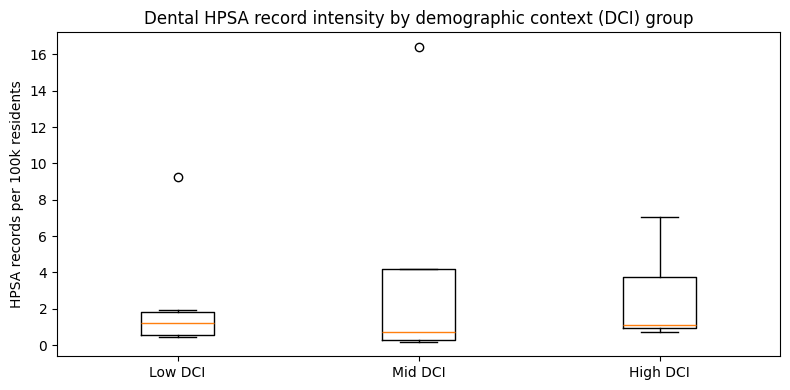

In [8]:
# Boxplot: intensity by group
plt.figure(figsize=(8,4))
data = [df.loc[df["dci_group"]==g, "hpsa_records_per_100k"].dropna() for g in ["Low DCI","Mid DCI","High DCI"]]
plt.boxplot(data, labels=["Low DCI","Mid DCI","High DCI"])
plt.ylabel("HPSA records per 100k residents")
plt.title("Dental HPSA record intensity by demographic context (DCI) group")
plt.tight_layout()
plt.show()


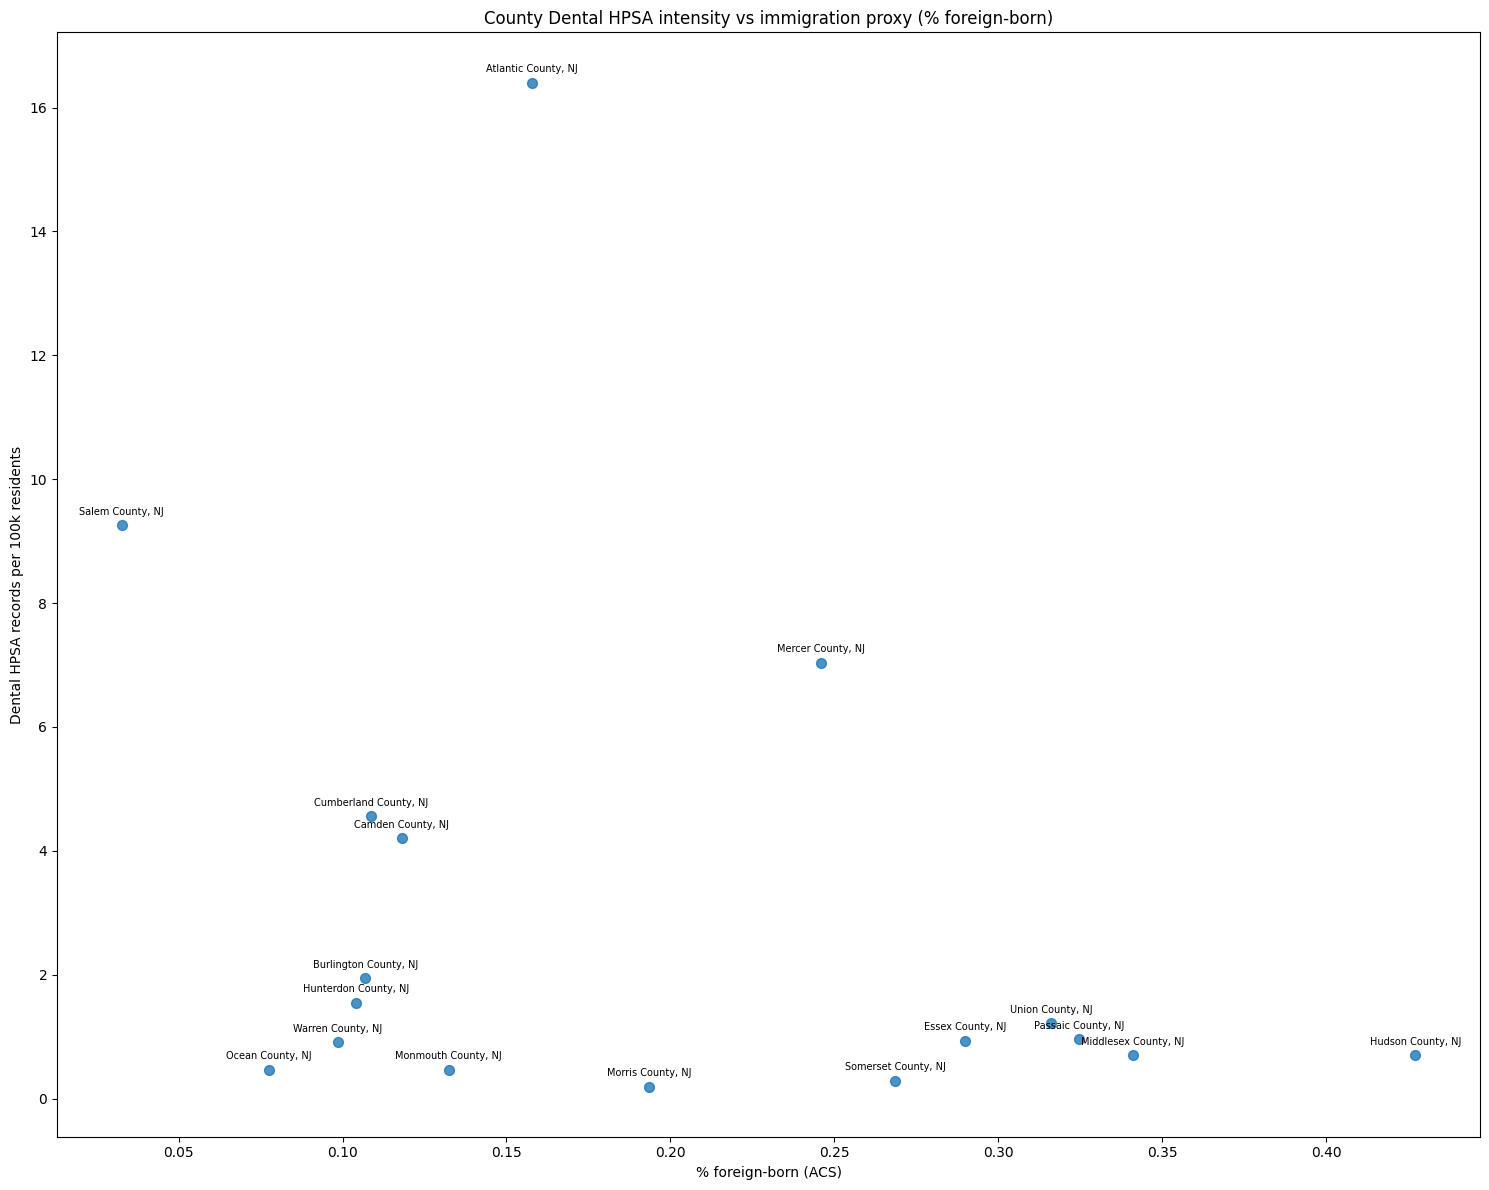

In [38]:
plt.figure(figsize=(15,12))

plt.scatter(
    df["pct_foreign_born"],
    df["hpsa_records_per_100k"],
    s=50,
    alpha=0.8
)

for _, r in df.iterrows():
    if pd.notna(r["county_name"]):
        plt.annotate(
            r["county_name"],
            (r["pct_foreign_born"], r["hpsa_records_per_100k"]),
            xytext=(0, 6),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7
        )

plt.xlabel("% foreign-born (ACS)")
plt.ylabel("Dental HPSA records per 100k residents")
plt.title("County Dental HPSA intensity vs immigration proxy (% foreign-born)")
plt.tight_layout()
plt.show()


## 7) Comparative structure: designation types by group

A key hypothesis for urban immigrant/minority contexts is that **designation structure** may differ
(more *population-group* or *facility* designations vs *geographic* designations).

We compute mean shares of designation types within each group.

> Note: These are shares of **record counts**, not shares of people covered.


In [10]:
type_cols = [c for c in df.columns if c.startswith("share_type__")]
type_group = df.groupby("dci_group")[type_cols].mean().T

# cleaner names
type_group.index = type_group.index.str.replace("share_type__", "", regex=False)
type_group = type_group.sort_values("High DCI", ascending=False)
type_group.head(15)


/tmp/ipython-input-506475805.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  type_group = df.groupby("dci_group")[type_cols].mean().T


dci_group,Low DCI,Mid DCI,High DCI
Federally Qualified Health Center,0.240741,0.574141,0.321649
Geographic HPSA,0.000000,0.216768,0.300000
HPSA Population,0.370370,0.128889,0.205291
Correctional Facility,0.222222,0.066667,0.152227
Federally Qualified Health Center Look A Like,0.166667,0.013535,0.020833


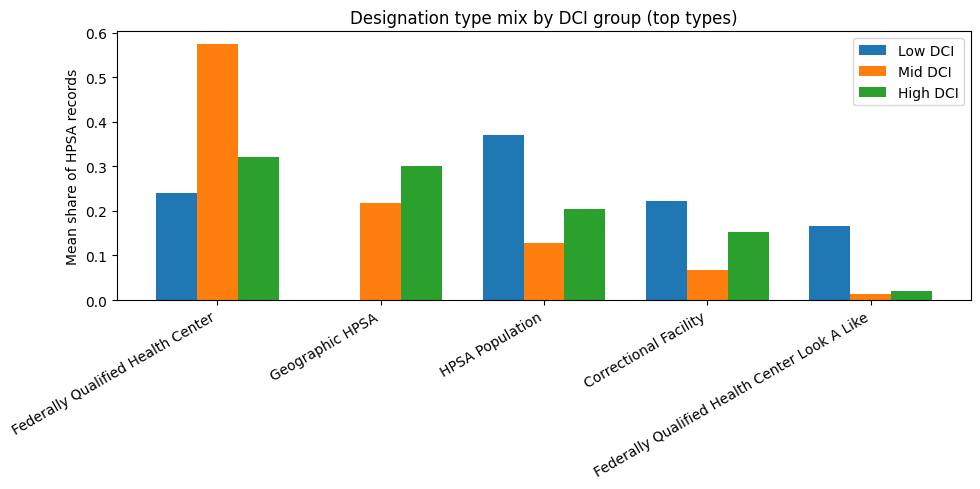

In [11]:
# Bar chart: top designation types
top_n = 8
plot_df = type_group.head(top_n)

plt.figure(figsize=(10,5))
x = np.arange(len(plot_df.index))
w = 0.25
plt.bar(x - w, plot_df["Low DCI"], width=w, label="Low DCI")
plt.bar(x,     plot_df["Mid DCI"], width=w, label="Mid DCI")
plt.bar(x + w, plot_df["High DCI"], width=w, label="High DCI")

plt.xticks(x, plot_df.index, rotation=30, ha="right")
plt.ylabel("Mean share of HPSA records")
plt.title("Designation type mix by DCI group (top types)")
plt.legend()
plt.tight_layout()
plt.show()


## 8) A conservative “equity lens” summary (no overreach)

We now produce a compact table you can cite in writing:
- County group (Low/Mid/High DCI)
- Intensity, severity, and designation-type mix

Then we list the counties that fall into High vs Low DCI for interpretability.


In [12]:
# counties by group (for narrative)
counties_by_group = (df[["county_name","dci_group","pct_foreign_born","pct_hispanic","pct_black","pct_limited_english_hh",
                         "hpsa_records_per_100k","hpsa_score_max","pct_high_severity_records"]]
                     .sort_values(["dci_group","pct_foreign_born"], ascending=[True, False]))

counties_by_group


,county_name,dci_group,pct_foreign_born,pct_hispanic,pct_black,pct_limited_english_hh,hpsa_records_per_100k,hpsa_score_max,pct_high_severity_records
9,"Monmouth County, NJ",Low DCI,0.132365,0.112616,0.065909,0.012619,0.466517,11,0.000000
1,"Burlington County, NJ",Low DCI,0.106926,0.089020,0.165189,0.006724,1.948672,22,0.111111
6,"Hunterdon County, NJ",Low DCI,0.104044,0.072781,0.025717,0.005959,1.549199,12,0.000000
16,"Warren County, NJ",Low DCI,0.098525,0.109578,0.051586,0.013613,0.911253,21,1.000000
11,"Ocean County, NJ",Low DCI,0.077662,0.097059,0.031017,0.005759,0.469711,20,0.333333
13,"Salem County, NJ",Low DCI,0.032665,0.103300,0.146391,0.015074,9.253547,0,0.000000
8,"Middlesex County, NJ",Mid DCI,0.341049,0.222600,0.102303,0.036719,0.697555,20,0.166667
14,"Somerset County, NJ",Mid DCI,0.268513,0.155013,0.095948,0.025932,0.289874,16,0.000000
10,"Morris County, NJ",Mid DCI,0.193396,0.141159,0.033828,0.023591,0.196535,15,0.000000
0,"Atlantic County, NJ",Mid DCI,0.157874,0.197486,0.135088,0.031620,16.403063,24,0.022222


## 9) Notes for interpretation (template language)

Use language like:

- “Counties in the High-DCI group show **[higher/lower]** record intensity per capita compared to Low-DCI counties.”
- “High-DCI counties also show a **different designation mix**, with a greater share of **[Population Group / Facility]** designations.”
- “This pattern suggests that shortage identification in urban immigrant/minority contexts may appear as **fragmented / population-targeted designations** rather than county-wide geographic designations.”

Avoid language like “ignored,” “undercounted,” or “unseen” unless you have supporting evidence beyond HRSA/ACS.

---

## 10) Export analysis table


In [14]:
EXPORT_PATH = os.path.join(os.getcwd(), 'nj_county_hpsa_acs_comparative.csv')
df.to_csv(EXPORT_PATH, index=False)
print("Saved:", EXPORT_PATH)


Saved: /content/nj_county_hpsa_acs_comparative.csv
